In [2]:
import torch 
import numpy as np
import torch.nn as nn

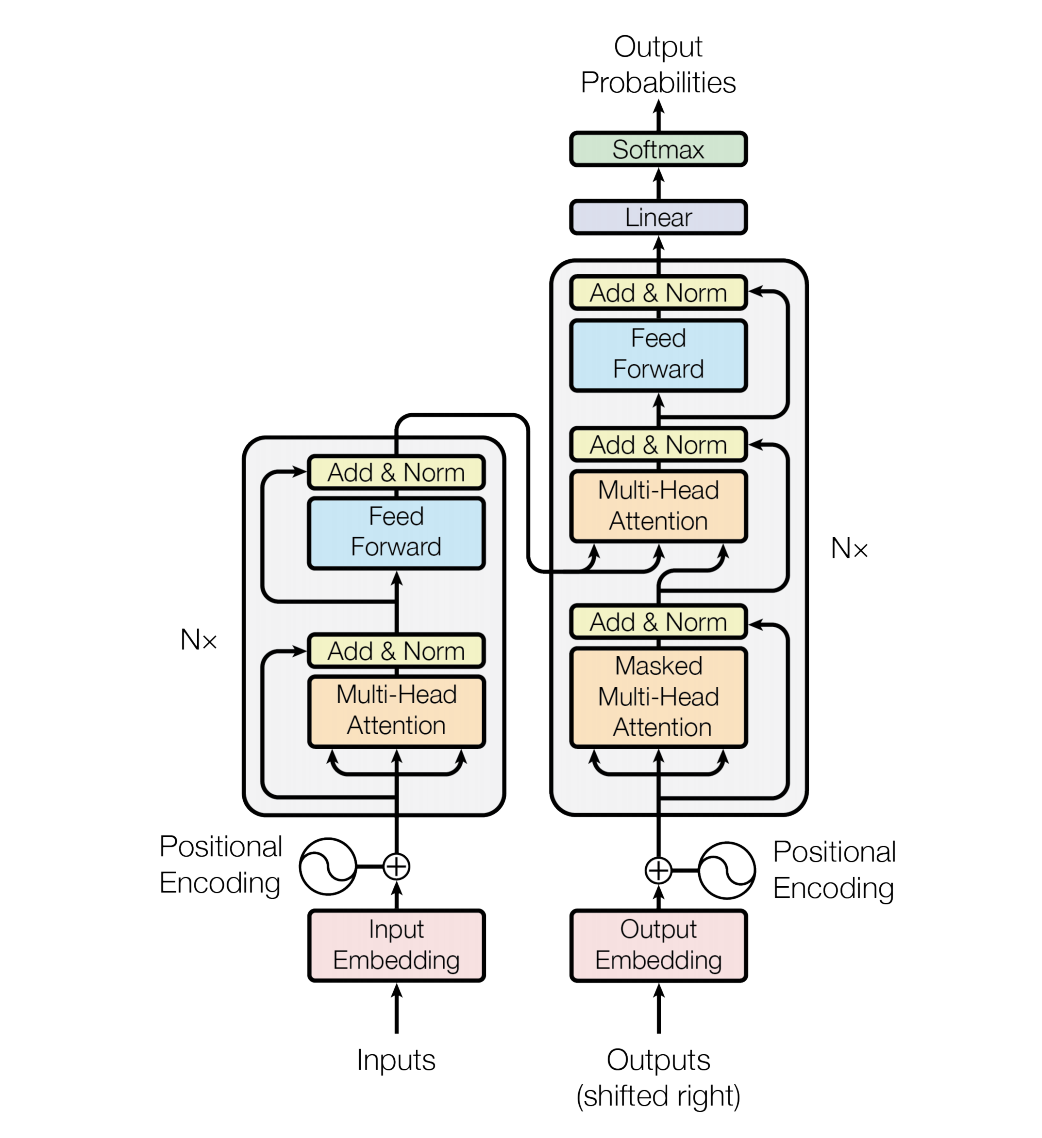

## Positional Encoding

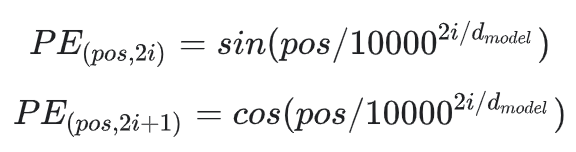

In [3]:
import torch
import torch.nn as nn
## this is to understand register buffer 
class ExampleModule(nn.Module):
    def __init__(self):
        super(ExampleModule, self).__init__()

        # Create a tensor and register it as a buffer
        tensor = torch.tensor([1, 2, 3])
        self.register_buffer('buffer_tensor', tensor)

    def forward(self, x):
        # Access the buffer tensor in the forward pass
        result = x + self.buffer_tensor
        return result

# Create an instance of the ExampleModule
example_module = ExampleModule()

# Print the buffer tensor
print(example_module(torch.tensor([8, 9, 10])))

# Perform a forward pass with an input tensor
input_tensor = torch.tensor([4, 5, 6])
output_tensor = example_module(input_tensor)

# Print the output tensor
print(output_tensor)

tensor([ 9, 11, 13])
tensor([5, 7, 9])


In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self,dim_model,max_seq_len,dropout_proba=0.1):
        super(PositionalEncoding,self).__init__()
        self.dim_model = dim_model
        self.max_seq_len = max_seq_len
        
        pe_table = self.get_pe_table()
        self.register_buffer("pe_table",pe_table)
        
        self.dropout = nn.Dropout(dropout_proba)
    def get_pe_table(self):
        position_idxs = torch.arange(self.max_seq_len).unsqueeze(1)
        # if I take max_seq_len =2
        #tensor([[0],
        #       [1]])
        embedding_idx = torch.arange(self.dim_model).unsqueeze(0)
        #tensor([[0, 1]])
        angle_rads = position_idxs * 1/torch.pow(10000,(2*embedding_idx//2)/self.dim_model)
        
        angle_rads[:,0::2] = torch.sin(angle_rads[:,0::2]) #0,2,4 positions
        angle_rads[:,1::2] = torch.cos(angle_rads[:,1::2]) #1,3,5 positions
        
        pe_table = angle_rads.unsqueeze(0)
        
        return pe_table
    def forward(self,embeddings_batch):
        seq_len = embeddings_batch.size(1)
        pe_batch = self.pe_table[:,:seq_len].clone().detach()
        return self.dropout(embeddings_batch + pe_batch)

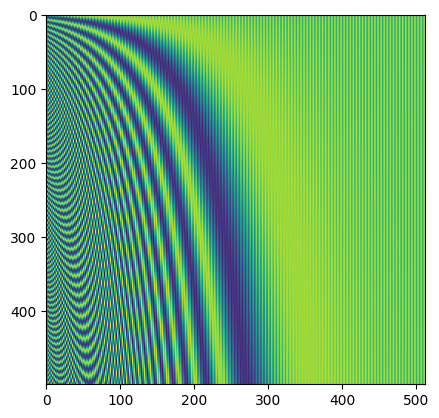

In [5]:
import matplotlib.pyplot as plt

positional_encoding = PositionalEncoding(512,500)
pe_table = positional_encoding.get_pe_table()

plt.imshow(pe_table.squeeze(0).numpy())

## Add & Norm Layer

In [6]:
class AddAndNorm(nn.Module):
    def __init__(self,dim_model):
        super(AddAndNorm,self).__init__()
        self.layer_norm =  nn.LayerNorm(dim_model)
    
    def forward(self,x,residual):
        return self.layer_norm(x + residual)

## Position-Wise FeedForward Layer

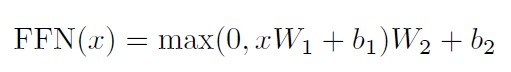

In [30]:
class PositionWiseFeedForwardNet(nn.Module):
    def __init__(self,dim_model,d_ff):
        super(PositionWiseFeedForwardNet,self).__init__()
        self.w_1 = nn.Linear(dim_model,dim_ff)
        self.w_2 = nn.Linear(dim_ff,dim_model)
        
        self.dropout = nn.Dropout(0.1)
    def forward(self,x):
        return self.w_2(self.dropout(torch.relu(self.w_1(x))))

## Multi Head Attention Layer

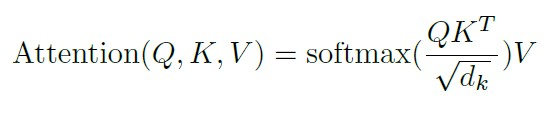

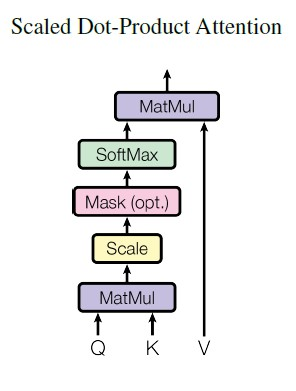

In [31]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dim_head):
        super(ScaledDotProductAttention, self).__init__()
        self.dim_head = dim_head
        self.attention_dropout = nn.Dropout(p=0.1)

    def forward(self, q, k, v, mask=None):
        # Compute attention weights
        attention_weights = torch.matmul(q, k.transpose(-2, -1))
        scaled_attention_weights = attention_weights / math.sqrt(self.dim_head)

        # Apply mask if provided
        if mask is not None:
            scaled_attention_weights = scaled_attention_weights.masked_fill(mask == 0, float("-inf"))

        # Apply softmax and dropout
        scaled_attention_weights = nn.functional.softmax(scaled_attention_weights, dim=-1)
        scaled_attention_weights = self.attention_dropout(scaled_attention_weights)

        # Compute weighted sum using attention weights
        weighted_v = torch.matmul(scaled_attention_weights, v)
        return weighted_v

## Multi Head Attention

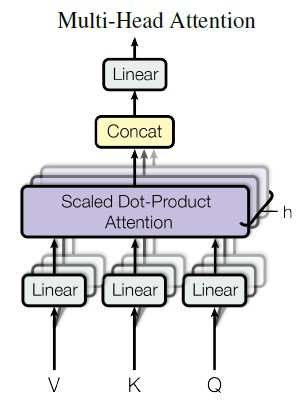

In [4]:
import torch
import torch.nn as nn
import math


class MultiHeadAttention(nn.Module):
    def __init__(self, dim_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        assert dim_model % num_heads == 0
        self.dim_head = dim_model // num_heads

        self.attention_layer = ScaledDotProductAttention(self.dim_head)
        self.w_0 = nn.Linear(dim_model, dim_model)

    def forward(self, q, k, v, mask=None):
        # Split input into multiple heads
        q, k, v = self.split_into_heads(q, k, v)

        # Apply multi-head attention
        attention_output = self.attention_layer(q, k, v, mask)

        # Concatenate attention outputs from all heads
        attention_output = self.concatenate_heads(attention_output)

        # Linear transformation
        attention_output = self.w_0(attention_output)
        return attention_output

    def split_into_heads(self, q, k, v):
        batch_size, seq_len, _ = q.size()

        # Reshape query, key, and value tensors to include heads
        q = q.view(batch_size, seq_len, self.num_heads, self.dim_head)
        k = k.view(batch_size, seq_len, self.num_heads, self.dim_head)
        v = v.view(batch_size, seq_len, self.num_heads, self.dim_head)

        # Transpose dimensions to bring heads dimension forward
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        return q, k, v

    def concatenate_heads(self, attention_output):
        batch_size, _, _, d_head = attention_output.size()

        # Transpose dimensions to bring heads dimension in the middle
        attention_output = attention_output.transpose(1, 2).contiguous()

        # Reshape the tensor by merging heads and d_head dimensions
        attention_output = attention_output.view(batch_size, -1, self.num_heads * d_head)

        return attention_output


In [8]:
## Differnet way to implement multiheadAttention


class MultiHeadAttention(nn.Module):
    def __init__(self, dim_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.dim_model = dim_model
        self.num_heads = num_heads
        self.dim_head = dim_model // num_heads

        self.q_linear = nn.Linear(dim_model, dim_model)
        self.k_linear = nn.Linear(dim_model, dim_model)
        self.v_linear = nn.Linear(dim_model, dim_model)
        self.output_linear = nn.Linear(dim_model, dim_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, q, k, v, mask=None):
        batch_size, seq_len, _ = q.size()

        # Apply linear transformations to q, k, v
        q = self.q_linear(q)
        k = self.k_linear(k)
        v = self.v_linear(v)

        # Reshape tensors for multi-head splitting
        q = q.view(batch_size, seq_len, self.num_heads, self.dim_head)
        k = k.view(batch_size, seq_len, self.num_heads, self.dim_head)
        v = v.view(batch_size, seq_len, self.num_heads, self.dim_head)

        # Transpose to bring the num_heads dimension to the front
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1))
        scores = scores / math.sqrt(self.dim_head)

        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))

        # Apply softmax
        attention_weights = torch.softmax(scores, dim=-1)

        # Apply dropout
        attention_weights = self.dropout(attention_weights)

        # Compute attention output
        attention_output = torch.matmul(attention_weights, v)

        # Transpose and reshape attention output
        attention_output = attention_output.transpose(1, 2).contiguous()
        attention_output = attention_output.view(batch_size, seq_len, self.dim_model)

        # Apply linear transformation
        output = self.output_linear(attention_output)

        return output


## Transformer Encoder Block

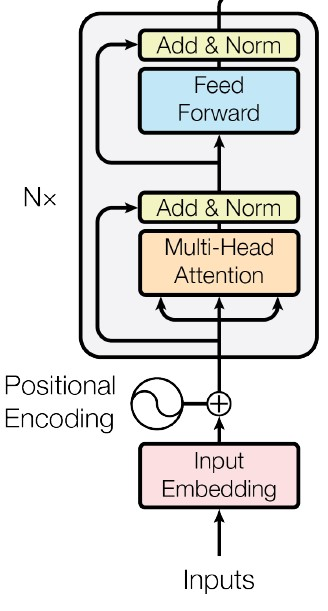

In [9]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,dim_model,num_heads,dim_ff,dropout_proba):
        super(TransformerEncoderBlock,self).__init__()
        self.W_q = nn.Linear(dim_model,dim_model)
        self.W_k = nn.Linear(dim_model,dim_model)
        self.W_v = nn.Linear(dim_model,dim_model)
        
        self.mha_layer = MulitHeadAttention(dim_model,num_heads)
        self.dropout_layer_1 = nn.Dropout(dropout_proba)
        self.add_and_norm_layer1 = AddAndNorm(dim_model)
        
        self.ffn_layer = PositionWiseFeedForwardNet(dim_model,dim_ff)
        self.dropout_layer_2   = nn.Dropout(dropout_proba)
        self.add_and_norm_layer2 = AddAndNorm(dim_model)
        
    def forward(self,x,mask):
        # x dim : (batch_size,src_seq_len,dim_model)
        # mask dim : (batch_size,1,1,src_seq_len)
        
        q = self.W_q(x) # (batch_size,src_seq_len,dim_model)
        k = self.W_k(x) # (batch_size,src_seq_len,dim_model)
        v = self.W_v(x) # (batch_size,src_seq_len,dim_model)
        
        mha_out = self.mha_layer(q,k,v,mask) # (batch_size,src_seq_len,dim_model)
        mha_out = self.dropout_layer_1(mha_out) # (batch_size,src_seq_len,dim_model)
        mha_out = self.add_and_norm_layer_1(x,mha_out) #(batch_size,src_seq_len,dim_model)
        
        ffn_out = self.ffn_layer(mha_out)#(batch_size,src_seq_len,dim_model)
        ffn_out = self.dropout_layer_2(ffn_out)#(batch_size,src_seq_len,dim_model)
        ffn_out = self.add_and_norm_layer2(mha_out,ffn_out) #(batch_size,src_seq_len,dim_model)
        
        return ffn_out        

## Transfomer Encoder

In [3]:
class TransformerEncoder(nn.Module):
    def __init__(self,num_blocks,num_heads,dim_model,dim_ff,dropout_proba=0.1):
        super(TransformerEncoder,self).__init__()
        self.encoder_blocks = nn.ModuleList([TransformerEncoderBlock(dim_model,num_heads,dim_ff,dropout_proba) for _ in range(n_blocks)])
    
    def forward(self,x,mask):
        for encoder in self.encoder_blocks:
            x = encoder_block(x,mask)
        return x

## Transformer Decoder Block

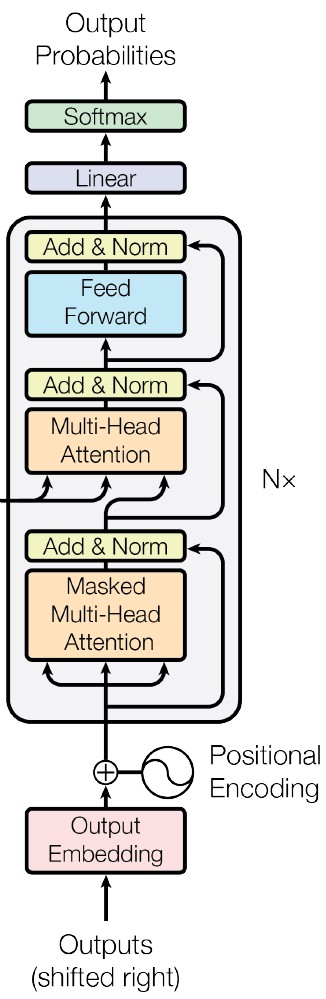

In [ ]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self,dim_model,num_head,dim_ff,dropout_proba):
        super(TransformerDecoderBlock,self).__init__()
        
        self.W_q_1 = nn.Linear(dim_model,dim_model)
        self.W_k_1 = nn.Linear(dim_model,dim_model)
        self.W_v_1 = nn.Linear(dim_model,dim_model)
        
        self.mha_layer_1 = MultiHeadAttention(dim_model,num_heads)
        self.dropout_layer_1 = nn.Dropout(dropout_proba)
        self.add_and_norm_1  = AddAndNorm(dim_model)
        
        self.W_q_2 = nn.Linear(dim_model,dim_model)
        self.W_k_2 = nn.Linear(dim_model,dim_model)
        self.W_v_2 = nn.Linear(dim_model,dim_model)
        
        self.mha_layer_2 = MultiHeadAttention(dim_model,num_heads)
        self.dropout_layer_2 = nn.Dropout(dropout_proba)
        self.add_and_norm_2  = nn.AddAndNorm(dim_model)
        
    def forward(self,x,encoder_output,src_mask,trg_mask):
        # x dims : (batch_size,trg_seq_len,dim_model)
        # encoder_output dim : (batch_size,src_seq_len,dim_model)
        # src_mask dim : (batch_size,1,1,src_seq_len)
        # trg_mask dim : (batch_size,1,trg_seq_len,trg_seq_len)
        
        # 1st attention Layer, trg_mask is used
        q_1 = self.W_q_1(x) #(batch_size,trg_seq_len,dim_model)
        k_1 = self.W_k_1(x) #(batch_size,trg_seq_len,dim_model)
        v_1 = self.W_v_1(x) #(batch_size,trg_seq_len,dim_model)
        
        mha_layer_1_out = self.mha_layer_1(q_1,k_1,v_1,trg_mask) ## (batch_size, trg_seq_len, dim_model)
        mha_layer_1_out = self.dropout_layer_1(mha_layer_1_out)# (batch_size, trg_seq_len, dim_model)
        mha_layer_1_out = self.add_and_norm_1(mha_layer_1_out,x)# (batch_size, trg_seq_len, dim_model)
        
        #2nd attention layer,src_mask is used here
        q_2 = self.W_q_2(x) #(batch_size,trg_seq_len,dim_model)
        k_2 = self.W_k_2(x) #(batch_size,trg_seq_len,dim_model)
        v_2 = self.W_v_2(x) #(batch_size,trg_seq_len,dim_model)
        
        mha_layer_2_out = self.mha_layer_2(q_2,k_2,v_2,trg_mask) ## (batch_size, trg_seq_len, dim_model)
        mha_layer_2_out = self.dropout_layer_2(mha_layer_2_out)# (batch_size, trg_seq_len, dim_model)
        mha_layer_2_out = self.add_and_norm_2(mha_layer_2_out,x)# (batch_size, trg_seq_len, dim_model)
        
        ffn_out = self.ffn_layer(mha_layer_2_out) #(batch_size,trg_seq_len,dim_model)
        ffn_out = self.dropout_layer_3(ffn_out) ##(batch_size,trg_seq_len,dim_model)
        ffn_out = self.add_and_norm_3(ffn_out,mha_layer_2_out) #(batch_size,trg_seq_len,dim_model)
        
        return ffn_out
        

In [4]:
class TransformerDecoder(nn.Module):
    def __init__(self,num_blocks,num_heads,dim_model,dim_ff,dropout_proba):
        super(TransformerDecoder,self).__init__()
        
        self.decoder_blocks = nn.ModuleList([TransformerDecoderBlock(dim_model,num_heads,dim_ff,dropout_proba) for _ in range(n_blocks)])
    def forward(self,x,encoder_output,src_mask,trg_mask):
        for decoder_block in self.decoder_blocks:
            x = decoder_block(x,encoder_output,src_mask,trg_mask)
        return x

## Full Encoder-Decoder Transformer

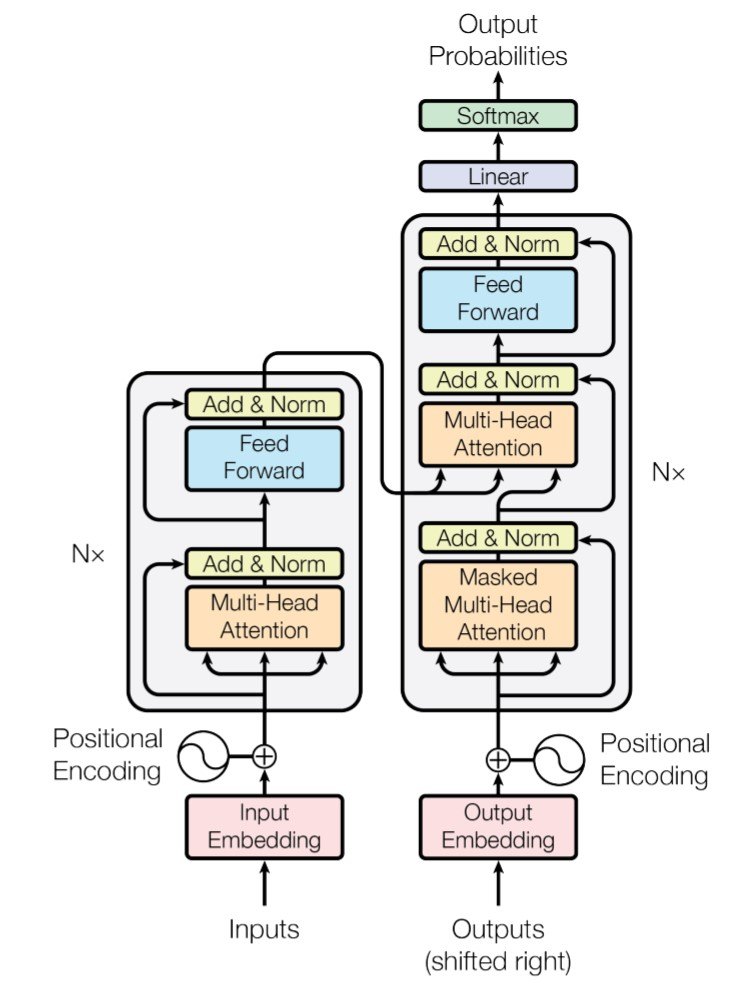

In [ ]:
class TransformerEncoderDecoder(nn.Module):
    def __init__(self,dim_model,num_blocks,src_vocab_size,trg_vocab_size,num_heads,dim_ff,dropout_proba):
        super(TransformerEncoderDecoder,self).__init__()
        self.dropout_proba = dropout_proba
        self.dim_model = dim_model
        
        #encoder part
        self.src_embedding = nn.Embedding(src_vocab_size,dim_model)
        self.src_pos_embeddings = PositionalEncoding(dim_model)
        self.enoder = TransformerEncoder(num_blocks,num_heads,dim_model,dim_ff,dropout_proba)
        
        #decoder part
        self.trg_embedding = nn.Embedding(trg_vocab_size,dim_model)
        self.trg_pos_embedding = PositionalEncoding(dim_model)
        self.decoder = TransformerDecoder(num_blocks,num_heads,dim_model,dim_ff,dropout_proba)
        
        # Linear mapping to Vocab Size
        self.linear = nn.Linear(dim_model,trg_vocab_size)

        # sharing weights between two embedding layers and the pre softmax linear layer
        self.src_embedding.weight = self.trg_embedding.weight
        self.linear.weight = self.trg_embedding.weight
        
    def encode(self,src_token_ids,src_mask)
        #Encoder Part
        src_embeddings = self.src_embedding(src_token_ids)*math.sqrt(self.dim_model) # (batch_size,src_seq_len,dim_model)
        src_embeddings = self.src_pos_embedding(src_embeddings) # (batch_size,src_seq_len,dim_model)
        encoder_outputs = self.encoder(src_embeddings,src_mask) # (batch_size,src_seq_len,dim_model)
        return encoder_outputs
    
    def decode(self,trg_token_ids,encoder_outputs,src_mask,trg_mask):
        # decoder Part
        trg_embeddings = self.trg_embedding(trg_token_ids) * math.sqrt(self.dim_model)
        trg_embeddings = self.trg_pos_embeddings(trg_embeddings)
        decoder_outputs = self.decoder(trg_embeddings,encoder_output,src_mask,trg_mask)
        
        # linear Maping to vocab size
        linear_out = self.linear(decoder_outputs)
        return linear_out
    
    def forward(self,src_token_ids,trg_token_ids,src_mask,trg_mask):
        encoder_outputs = self.encode(src_token_ids,src_mask)
        decoder_output  = self.decode(trg_token_ids,encoder_outputs,src_mask,trg_mask)
        return decoder_outputs
    

References

1. https://twitter.com/abhi1thakur/status/1470406419786698761

2. https://nlp.seas.harvard.edu/2018/04/03/attention.html (Too long)

3. https://github.com/brandokoch/attention-is-all-you-need-paper/tree/master

4. https://machinelearningmastery.com/the-attention-mechanism-from-scratch/ (Only attention understanding)

5. https://nn.labml.ai/transformers/mha.html (MultiHead Attention)
